# Intuit Quickbooks Upgrade

* Team-lead GitHub userid: rsm-yuc172
* Group name: group32
* Team member names:
    - Yu Chien (Jack) Chen
    - Joshua Chen
    - Jia-Huei (Mandy) Liou
    - David Yang

## Write Up

#### Describe how you developed your predictive models, and discuss predictive performance for each model
We developed a total of 5 main predictive models that were used to try and predict.
- Logistic Regression 1: Logistic Regression that uses all the original variables
- Logistic Regression 2: Logistic Regression that uses all the original variables and an extra variable 'isweird'
- Logistic Regression 3: Logistic Regression that uses all the original variables and an extra varialbe 'isweird' and interaction effects we found through Neural Network
- MLP1 : MLP Classifier that uses all the original variables and an extra varialbe 'isweird' and fine tuned for max profit
- Spamming: Spam everyone

We first started with Logistic Regression 1, and from the prediction plots, we realized that zip_bins = 1 have a significantly higher chance of responding. We then did some explanatory data analysis and found that zip codes 00801 and 00804 were anomalies, which we then created a variable isweird to reflect these anomalies. 

Logistic Regression 2 was then developed with the added variable, we also merged version1 and upgraded into version_upgrade to interpret the prediction plot.

We then decided to look into Neural Networks to see if Neural Network can provide insight into how the logistic regression can be further improved. While adding more layers, we realized that on the importance graph, some variables' importance seem to fluctuate. We saw sex, last, and version_upgrade fluctuate the most. However, by only including the layers in the Neural Network, the max profits did not increase, so we excluded these Neural Network as models for prediction.

As a result of our findings in Neural Network, we determined that some interaction effects are 'sex and zip_bins','isweird and version_upgrade', 'isweird and numords'. By adding these as the interaction variables, we came up with Logistic Regression 3.

We then decided to run a gridsearch on Neural Network and eventually found MLP1, which significantly outperformed the rest of the classifier. Which was why we went with MLP1 as our final model

Model Performances:

| Model   | prediction on test  | projected prediction | ROME |
| ---    | ---   | ---     |---|
| LR1    | 35158.83   | 1192795.11     | 3.59|
| LR2 | 35444.61 | 1202490.81 | 3.88|
| LR3 | 35940.9 | 1219324.02 | 3.92|
| MLP1 | 36125.4 | 1225587.45 | 3.63|

Even though LR3 have similar projected prediction and a higher ROME, since our objective is the maximize profit, we eventually went with MLP1 as it resulted in the highest profit
#### How did you compare and evaluate different models?
To compare and evaluate different models, we primarily focused on the confusion matrix, which helped us understand the breakdown of true positives, true negatives, false positives, and false negatives. This was crucial, especially in contexts where false negatives are particularly costly. We also assessed the profit on the test set and projected profit, providing a direct financial perspective on model performance. Additionally, the cumulative gains plot reveals what proportion of responders we can get from targeting a specific proportion of customers. Thus, it greatly helps us compare model performance.
#### If you created new variables to include in the model, please describe these as well
We created 2 new varialbes, isweird where if the zipcode is 00801 and 00804, isweird is 1 else 0. The reason is because 00801 and 00804 appears to have significantly higher rates of responding to the first wave compared to other zip codes

The other variable is version_upgrade, which merges version1 and upgraded to make the prediction plots easier to interpret.

#### What criteria did you use to decide which customers should receive the wave-2 mailing?
The criteria is which businesses have a predicted response probability from the best model (MLP1), divided by 2 (since we expect response rate to be 50% of wave-1) and greater than the break even response rate, which was 0.0235.

#### How much profit do you anticipate from the wave-2 mailing?
We expect a profit of 1225587.45 from wave-2 mailing

#### What did you learn about the type of businesses that are likely to upgrade?
We learned that 
- businesses in zip codes 00801 and 00804 are the most likely to upgrade
- those who previously upgraded to version 2 are more likely to buy,followed by those who are still on version 1, those who directly bought version 2 are less likely to upgrade
- The more recent the last purchase, the more likely they are to upgrade
- The more money they spent, the more likely they are the upgrade 
- Males in certain zip_bins are more likely to upgrade
- Those in 00801 and 00804, if they directly bought version 2 are more likely to upgrade

### How we use Gen-AI?

We include a pdf file called "ChatGPT" in the repo. Welcome to take a look at it and see how we employ Gen-AI to help our works!!!

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from utils import functions

In [2]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_parquet("data/intuit75k.parquet")
intuit75k["res1_yes"] = rsm.ifelse(intuit75k.res1 == "Yes", 1, 0)

### Exploratory Data Analysis

In [3]:
df = intuit75k.drop(columns=['zip5','id', 'sex', 'res1', 'training'])
counts = df.groupby('zip_bins').size().reset_index(name='counts')
result = df.groupby('zip_bins').mean().sort_values(by='res1_yes', ascending=False).reset_index()
result = result.merge(counts, on='zip_bins')

In [4]:
result

,zip_bins,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1_yes,counts
0,1,0.256055,2.052169,90.706947,15.875433,15.775087,0.222518,0.028480,0.210540,0.218525,3757
1,18,0.249338,2.084261,94.126259,15.827239,15.841547,0.210652,0.030207,0.212772,0.051934,3774
2,12,0.251199,2.068993,91.599893,15.892381,15.506926,0.203250,0.026372,0.212573,0.049281,3754
3,19,0.252818,2.087762,93.701288,15.894525,15.765969,0.211755,0.026838,0.213097,0.043747,3726
4,2,0.235247,2.070227,91.963952,15.795728,15.449933,0.209613,0.027770,0.205073,0.043258,3745
5,4,0.255665,2.068248,92.840043,15.680352,15.937883,0.220208,0.029059,0.217542,0.041589,3751
6,17,0.240192,2.103816,94.555778,15.676274,15.329597,0.213237,0.032026,0.198025,0.039498,3747
7,20,0.244130,2.087247,92.645411,15.578975,15.694771,0.211580,0.028815,0.214514,0.039221,3748
8,10,0.248530,2.062801,91.298771,15.977285,15.826563,0.219936,0.030732,0.211919,0.038215,3742
9,11,0.252601,2.072019,93.629901,16.086156,15.781275,0.217391,0.033075,0.209656,0.037877,3749


#### It appears that zip_bins = 1 have a significantly higher chance of buying, let's investigate which zipcodes those are

In [5]:
df = intuit75k[intuit75k['zip_bins']==1].drop(columns=['id', 'sex', 'res1', 'training'])
counts = df.groupby('zip5').size().reset_index(name='counts')
result = df.groupby('zip5').mean().sort_values(by='res1_yes', ascending=False).reset_index()
result = result.merge(counts, on='zip5')

In [6]:
result[(result['counts'] > 50) &(result['res1_yes'] > 0.3)]

,zip5,zip_bins,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1_yes,counts
1,00801,1.0,0.265588,2.013789,89.764089,15.755995,15.637290,0.221223,0.025180,0.200240,0.412470,1668
2,00804,1.0,0.209677,2.032258,75.846774,16.139785,17.043011,0.268817,0.026882,0.247312,0.344086,186


#### It appears that people in zipcode 00801 and 00804 have a significantly high chance of buying, hence skewing the results for zip_bins = 1

#### Now we check whether there are other zip codes outside zip_bins = 1 that have a high chance of buying and have a lot of counts

In [7]:
df = intuit75k.drop(columns=['id', 'zip_bins', 'sex', 'res1', 'training'])
counts = df.groupby('zip5').size().reset_index(name='counts')
result = df.groupby('zip5').mean().sort_values(by='res1_yes', ascending=False).reset_index()
result = result.merge(counts, on='zip5')

In [8]:
result[(result['res1_yes'] > 0.2) & (result['counts'] > 40)].sort_values(by='counts', ascending = False)

,zip5,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1_yes,counts
57,00801,0.265588,2.013789,89.764089,15.755995,15.637290,0.221223,0.025180,0.200240,0.412470,1668
63,00804,0.209677,2.032258,75.846774,16.139785,17.043011,0.268817,0.026882,0.247312,0.344086,186


#### None of the other zipcodes appear to be like these 2 anomaly. We will create a separate variable that documents whether or not the zip codes are from 00801 and 00804

In [9]:
value_list = ['00801', '00804']  

intuit75k['isweird'] = intuit75k['zip5'].apply(lambda x: 1 if x in value_list else 0)

#### To see if it truly make a difference, we will run logistic regression on all the original variables and compare it with a model that added this distinction

#### Preprocessing, changing columns to categorical variable

In [10]:
intuit75k['zip_bins'] = intuit75k['zip_bins'].astype('category')
intuit75k['version1'] = intuit75k['version1'].astype('category')
intuit75k['owntaxprod'] = intuit75k['owntaxprod'].astype('category')
intuit75k['upgraded'] = intuit75k['upgraded'].astype('category')
intuit75k['bizflag'] = intuit75k['bizflag'].astype('category')
intuit75k['isweird'] = intuit75k['isweird'].astype('category')

In [11]:
lr = rsm.model.logistic(data = {'Intuit':intuit75k[intuit75k['training'] == 1]}, rvar = 'res1_yes', lev = 1, evar = ['zip_bins', 'sex', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'version1', 'owntaxprod', 'upgraded'])

In [12]:
functions.get_pred(intuit75k, 'pred_1', lr)
functions.confusion_matrix(intuit75k[intuit75k['training'] == 0], 'pred_1')

,label,nr
0,TP,749
1,FP,6188
2,TN,15209
3,FN,354


In [13]:
functions.calc_profit(intuit75k[intuit75k['training']==0], 'pred_1')

(35158.83, 3.594542370697984)

In [14]:
functions.calc_profit_scaled(intuit75k[intuit75k['training']==0], 'pred_1')

(1192795.1113622603, 3.594542370697984)

#### Model with added zip distinction

In [15]:
lr1 = rsm.model.logistic(data = {'Intuit':intuit75k[intuit75k['training'] == 1]}, rvar = 'res1_yes', lev = 1, evar = ['zip_bins', 'sex', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'version1', 'owntaxprod', 'upgraded', 'isweird'])

In [16]:
functions.get_pred(intuit75k, 'pred_2', lr1)
functions.confusion_matrix(intuit75k[intuit75k['training'] == 0], 'pred_2')

,label,nr
0,TP,743
1,FP,5736
2,TN,15661
3,FN,360


In [17]:
functions.calc_profit(intuit75k[intuit75k['training']==0], 'pred_2')

(35444.61, 3.8799230246327747)

In [18]:
functions.calc_profit_scaled(intuit75k[intuit75k['training']==0], 'pred_2')

(1202490.8080969285, 3.8799230246327747)

#### We can see that the ROME and profit increased 

In [19]:
lr.summary()

Logistic regression (GLM)
Data                 : Intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, sex, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                  OR     OR%  coefficient  std.error  z.value p.value     
Intercept      0.181  -81.9%        -1.71      0.092  -18.507  < .001  ***
zip_bins[2]    0.148  -85.2%        -1.91      0.110  -17.296  < .001  ***
zip_bins[3]    0.118  -88.2%        -2.14      0.121  -17.710  < .001  ***
zip_bins[4]    0.136  -86.4%        -2.00      0.112  -17.811  < .001  ***
zip_bins[5]    0.116  -88.4%        -2.15      0.120  -17.894  < .001  ***
zip_bins[6]    0.126  -87.4%        -2.07      0.115  -18.043  < .001  ***
zip_bins[7]    0.121  -87.9%        -2.11      0.117  -17.970  < .001  ***
zip_bins[8]    0.131  -86.9%        -2.03      0.114  -17.844  < .001  ***
zip

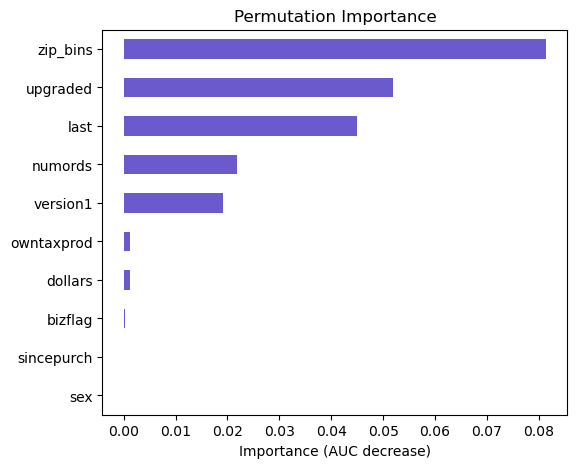

In [20]:
lr.plot('vimp')

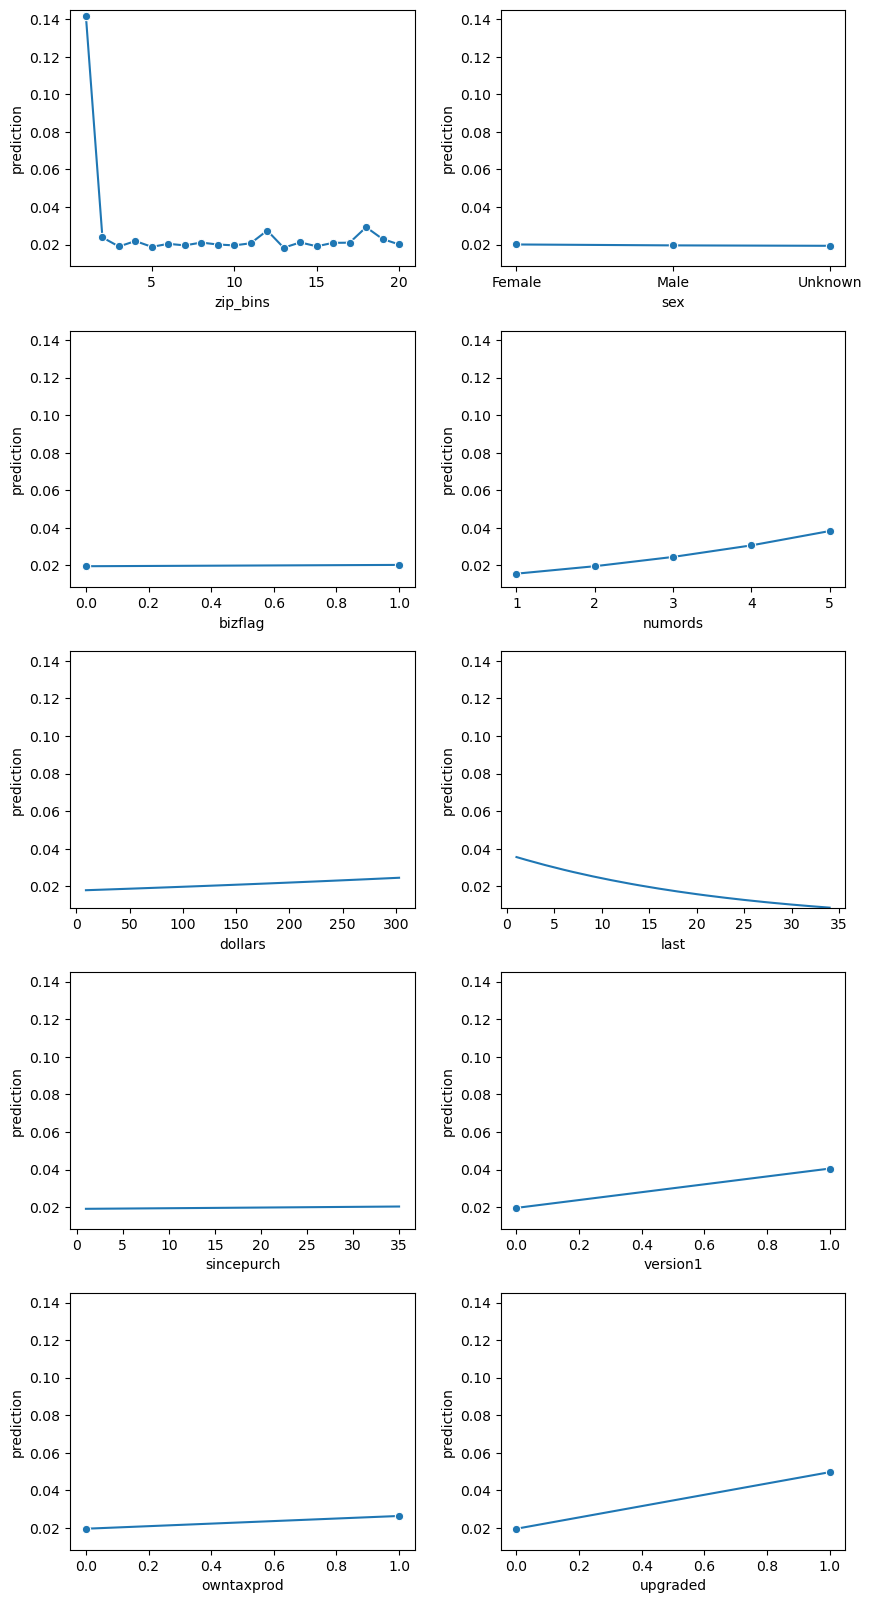

In [21]:
lr.plot('pred')

In [22]:
lr1.summary()

Logistic regression (GLM)
Data                 : Intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, sex, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded, isweird
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                   OR      OR%  coefficient  std.error  z.value p.value     
Intercept       0.019   -98.1%        -3.95      0.172  -22.981  < .001  ***
zip_bins[2]     1.300    30.0%         0.26      0.180    1.457   0.145     
zip_bins[3]     1.031     3.1%         0.03      0.187    0.164    0.87     
zip_bins[4]     1.189    18.9%         0.17      0.181    0.956   0.339     
zip_bins[5]     1.020     2.0%         0.02      0.186    0.108   0.914     
zip_bins[6]     1.107    10.7%         0.10      0.183    0.557   0.578     
zip_bins[7]     1.063     6.3%         0.06      0.184    0.331   0.741     
zip_bins[8]     1.147    14.7%         0.14      0.18

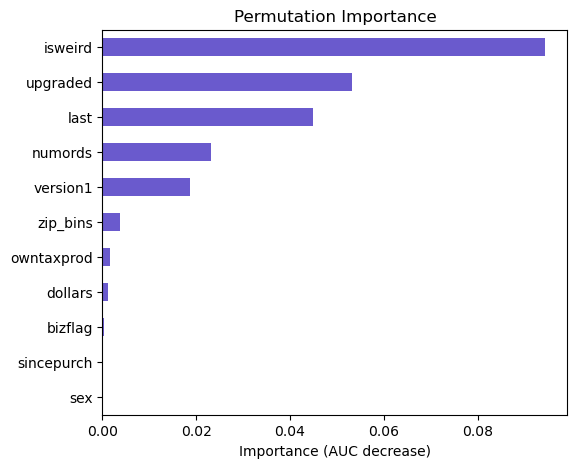

In [23]:
lr1.plot('vimp')

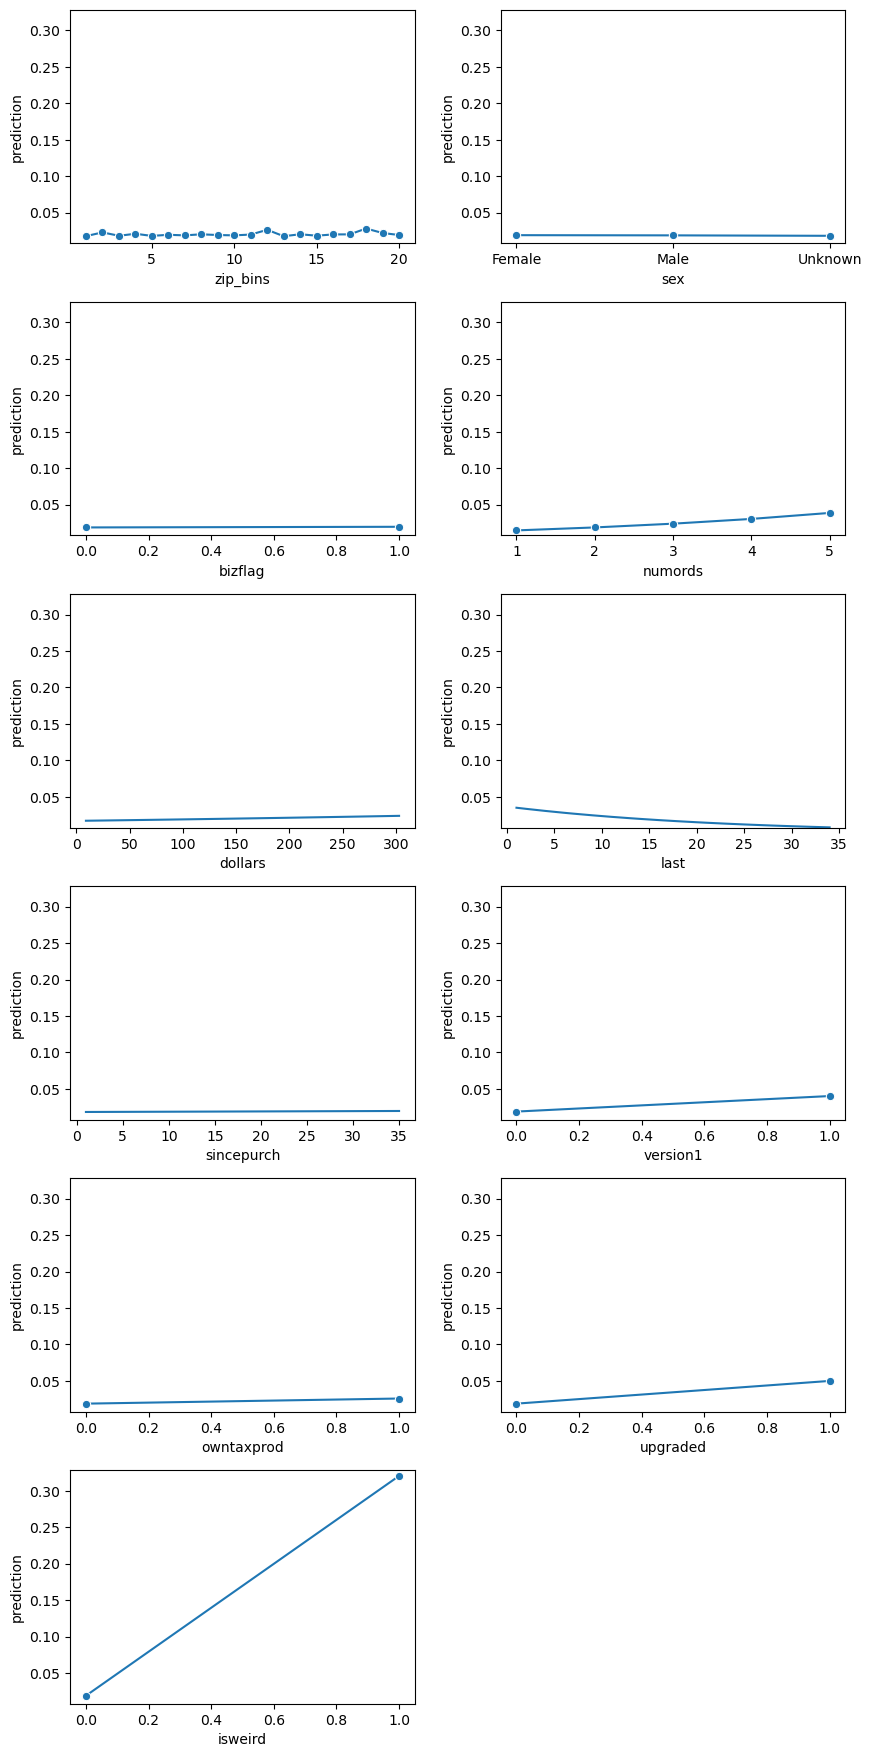

In [24]:
lr1.plot('pred')

#### It appears that there was interaction effect on zip_bins with all the other variables, after adding distinction to which zip_codes were anomolies, zip_bins is now no longer significant. Therefore, moving on from this point, we will be keeping the isweird variable

In [25]:
lrbase = rsm.model.logistic(data = {'Intuit':intuit75k[intuit75k['training'] == 1]}, rvar = 'res1_yes', lev = 1, evar = ['sex', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'version1', 'owntaxprod', 'upgraded', 'isweird', 'zip_bins'])
functions.get_pred(intuit75k, 'pred_base', lrbase)
functions.confusion_matrix(intuit75k[intuit75k['training'] == 0], 'pred_base')

,label,nr
0,TP,743
1,FP,5736
2,TN,15661
3,FN,360


In [26]:
functions.calc_profit(intuit75k[intuit75k['training'] == 0], 'pred_base')

(35444.61, 3.8799230246327747)

In [27]:
functions.calc_profit_scaled(intuit75k[intuit75k['training'] == 0], 'pred_base')

(1202490.8080969285, 3.8799230246327747)

#### Now we evaluate take a closer look on the prediction plots

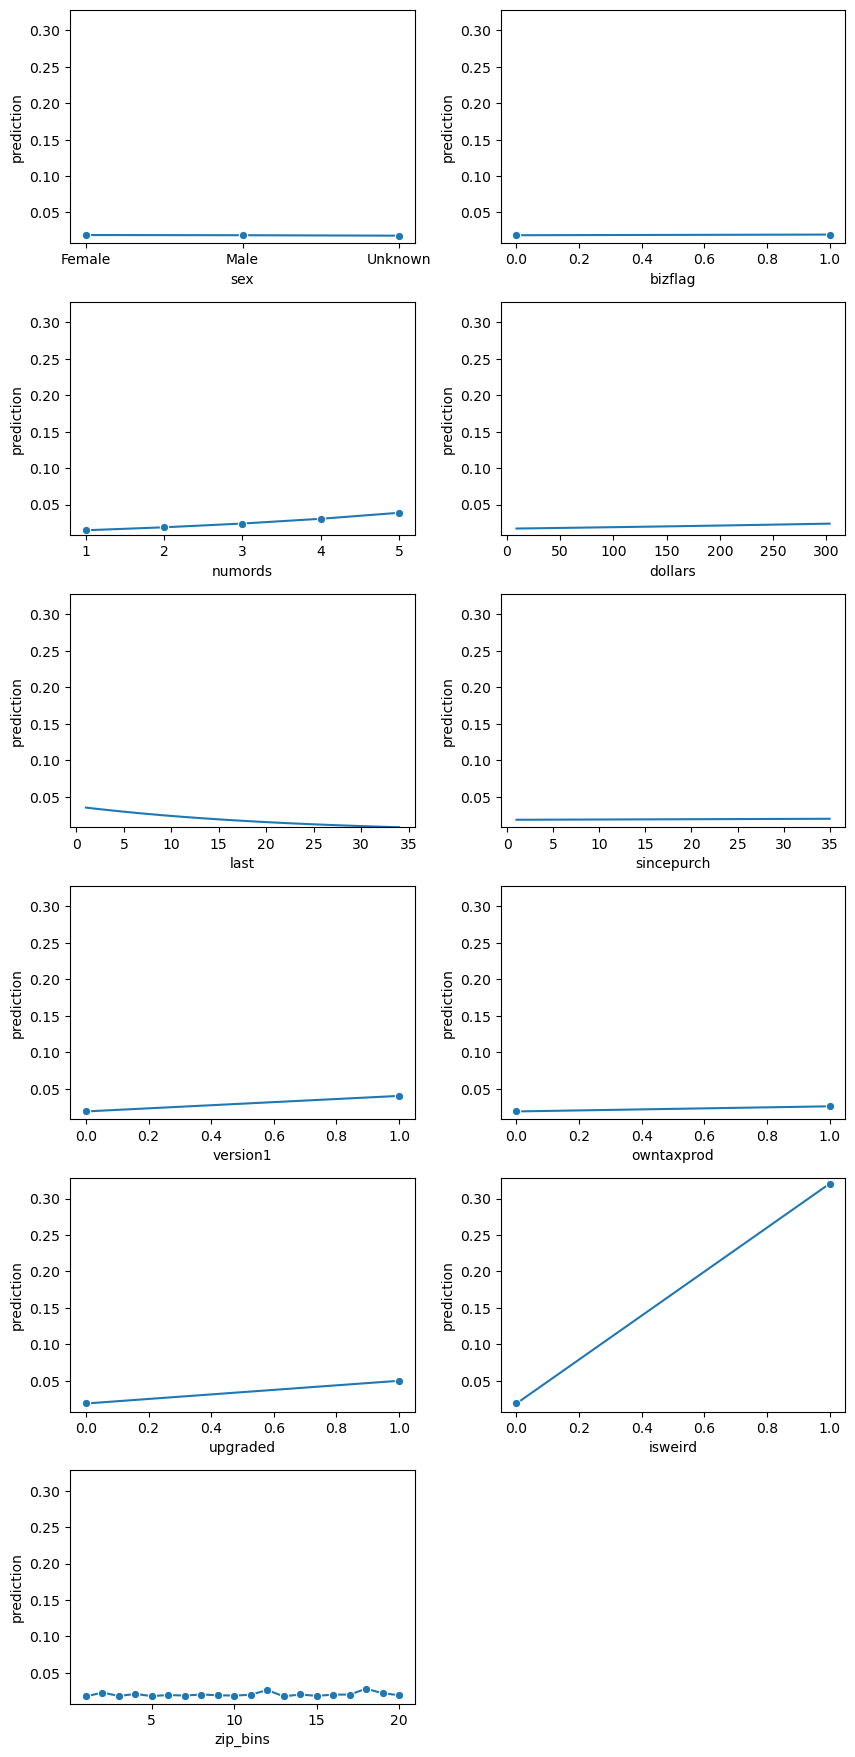

In [28]:
lrbase.plot('pred')

Interestingly, people on version 1 are more likely to upgrade, but people that did not upgrade to version 2 and stayed at version 1 are less likely to upgrade, as a result, we've decided to combine the upgraded and version 1 variables with the following rules:

1, 1 has none (version 1 and upgraded, does not make sense so there are none in the dataset)

1, 0 has 16050 (version 1 and not upgraded) combined to 0 in new dataset

0, 1 has 15629 (version 2 and upgraded) combined to 1 in new column

0, 0 has 43321 (version 2 and not upgraded) (directly bought version 2) combined to 2 in new column

In [29]:
def create_new_category(version1, upgraded):
    if version1 == 1 and upgraded == 0:
        return 0
    elif version1 == 0 and upgraded == 1:
        return 1
    elif version1 == 0 and upgraded == 0:
        return 2

In [30]:
intuit75k['version_upgrade'] = intuit75k.apply(lambda row: create_new_category(row['version1'], row['upgraded']), axis=1)
intuit75k['version_upgrade'] = intuit75k['version_upgrade'].astype('category')

#### Model with version_upgrade combined 

In [31]:
lrfinal2 = rsm.model.logistic(data = {'Intuit':intuit75k[intuit75k['training'] == 1]}, rvar = 'res1_yes', lev = 1, evar = ['zip_bins','isweird', 'sex', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'owntaxprod', 'version_upgrade'])

In [32]:
functions.get_pred(intuit75k, 'pred_base2', lrfinal2)

'prediction generated'

In [33]:
list(intuit75k['pred_base']) == list(intuit75k['pred_base2'])

True

#### The predictions are the same, therefore, moving forward we will be using version_upgrade instead of version1 and upgraded

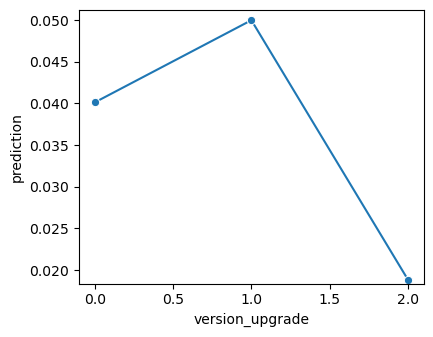

In [34]:
lrfinal2.plot('pred', excl=['isweird', 'sex', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'owntaxprod', 'zip_bins'])

It appears that those who previously upgraded to version 2 are more likely to buy,followed by those who are still on version 1, those who directly bought version 2 are less likely to upgrade

### There's always the possibility that spamming results in higher profit, we have to test that as well

In [35]:
intuit75k['pred_spam'] = True

In [36]:
functions.confusion_matrix(intuit75k[intuit75k['training'] == 0], 'pred_spam')

,label,nr
0,TP,1103
1,FP,21397
2,TN,0
3,FN,0


In [37]:
functions.calc_profit(intuit75k[intuit75k['training'] == 0], 'pred_spam')

(34455.0, 1.0860520094562647)

In [38]:
functions.calc_profit_scaled(intuit75k[intuit75k['training'] == 0], 'pred_spam')

(1168918.7986666672, 1.0860520094562653)

#### Spamming does not appear to result in highest profit, therefore we have to try neural networks and other models to try and improve model

### Now we will try neural network

In [39]:
intuit75k2 = rsm.scale_df(intuit75k, sf=1)

In [40]:
clf = rsm.model.mlp(data = {'Intuit':intuit75k2[intuit75k2['training'] == 1]}, rvar = 'res1_yes', lev = 1, evar = ['zip_bins','isweird', 'sex', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'version_upgrade', 'owntaxprod'], hidden_layer_sizes = (1,), mod_type = 'classification')

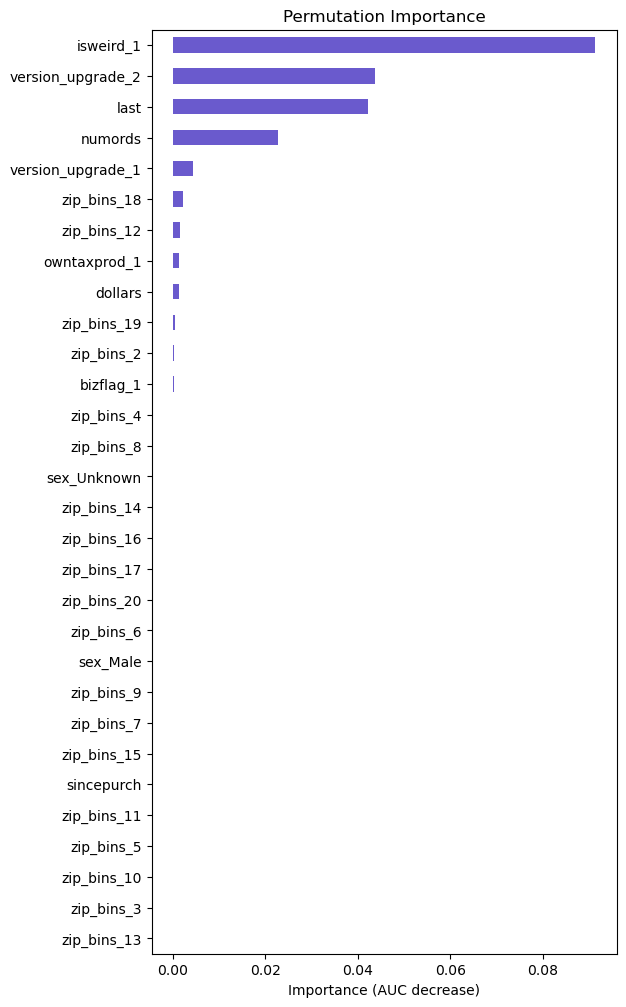

In [41]:
clf.plot('vimp')

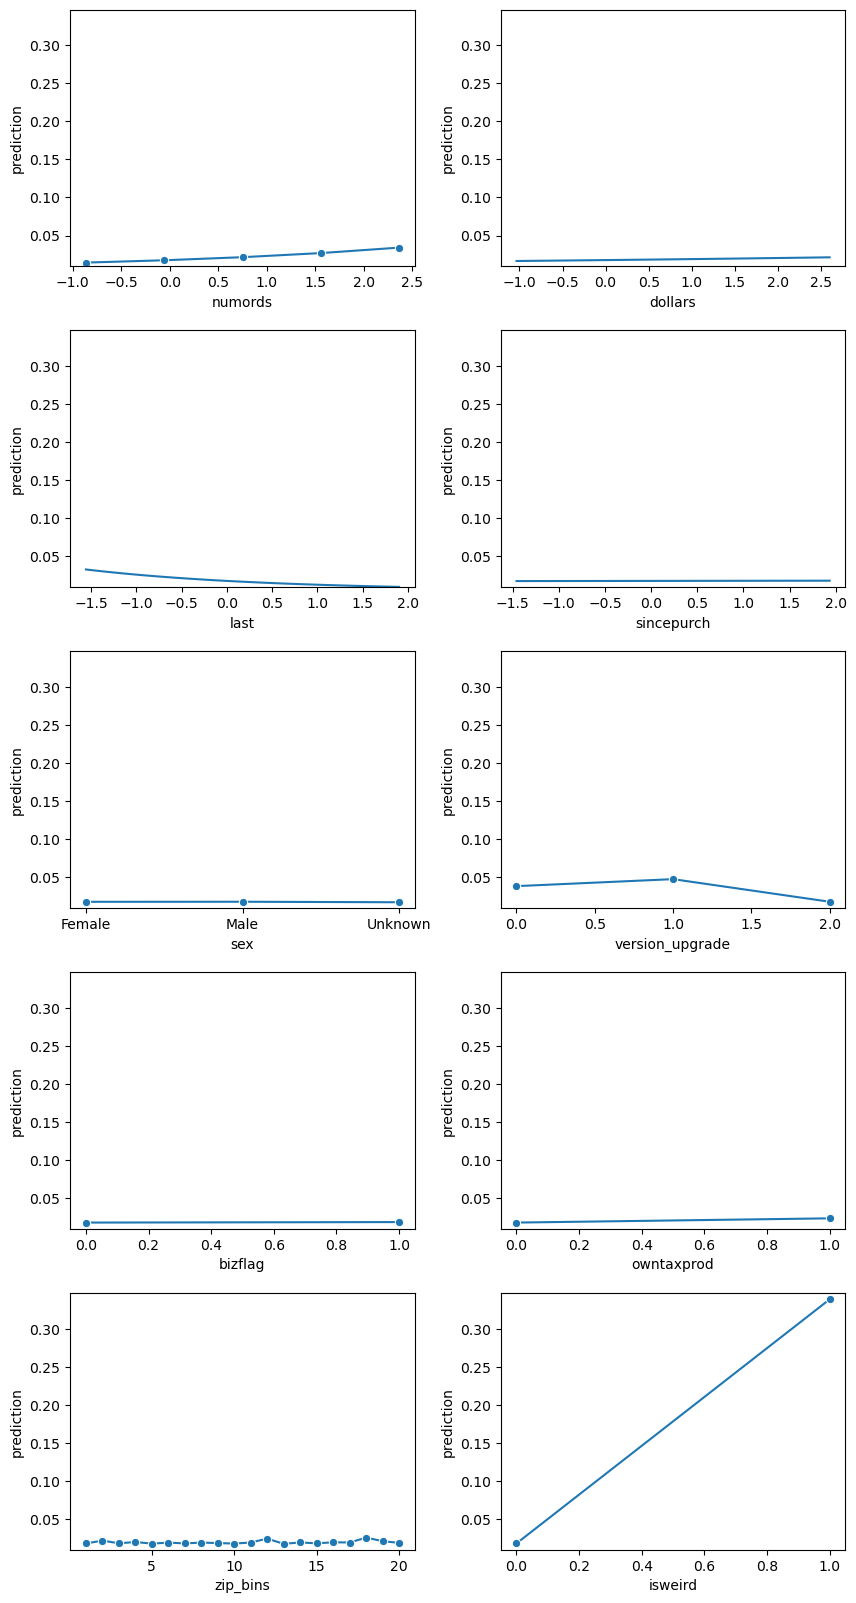

In [42]:
clf.plot('pred')

#### Since there's only one layer, doesn't seem to be much different. This is to be expected as a Neural Net with one layer is essentially similar to a logistic regression

### Adding Layers

In [43]:
clf2 = rsm.model.mlp(data = {'Intuit':intuit75k2[intuit75k2['training'] == 1]}, rvar = 'res1_yes', lev = 1, evar = ['zip_bins','isweird', 'sex', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'version_upgrade', 'owntaxprod'], hidden_layer_sizes = (2,), mod_type = 'classification')

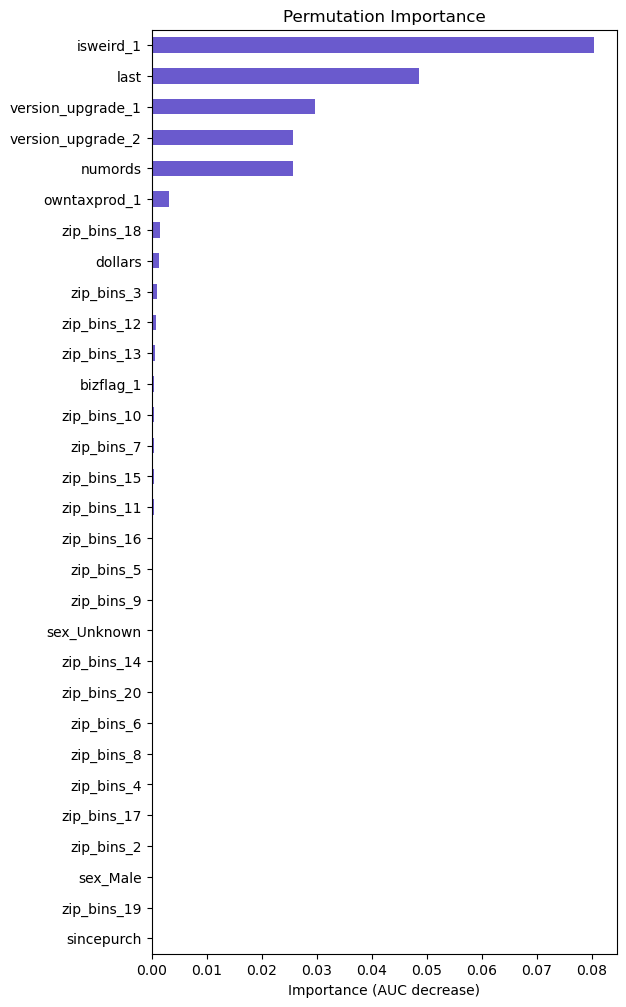

In [44]:
clf2.plot('vimp')

In [45]:
clf3 = rsm.model.mlp(data = {'Intuit':intuit75k2[intuit75k2['training'] == 1]}, rvar = 'res1_yes', lev = 1, evar = ['zip_bins','isweird', 'sex', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'version_upgrade', 'owntaxprod'], hidden_layer_sizes = (10,), mod_type = 'classification')

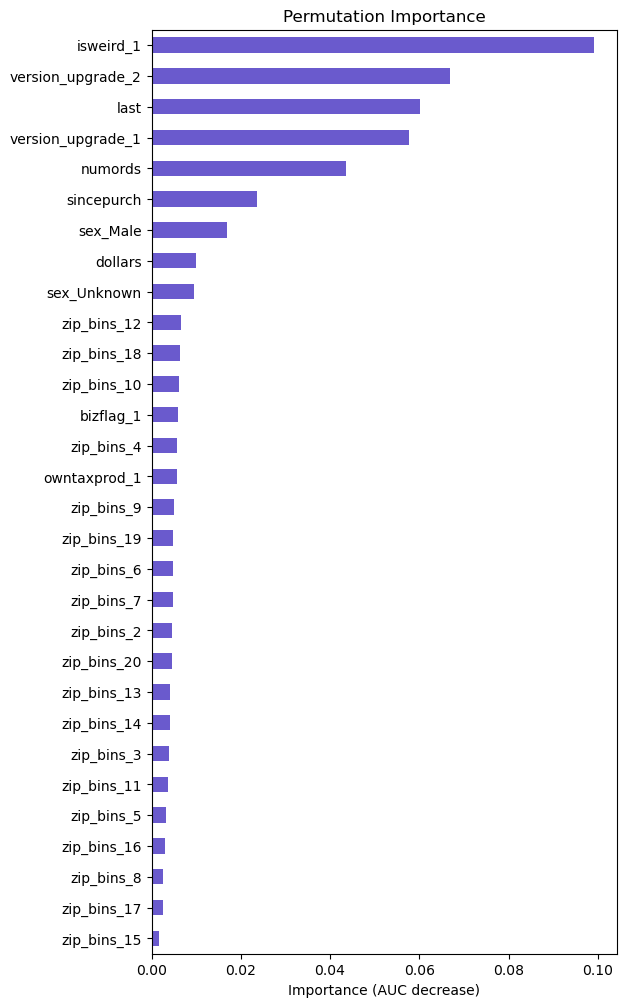

In [46]:
clf3.plot('vimp')

#### Importance of last seems to rise, we will check prediction plots for potential interaction effects

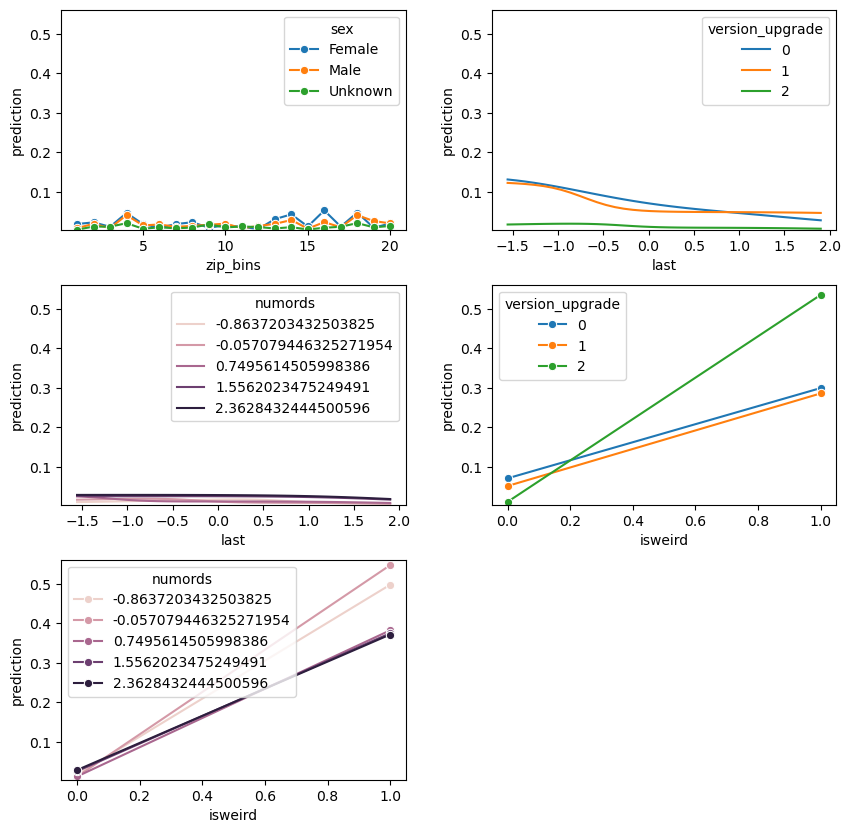

In [47]:
clf3.plot('pred', incl = [], incl_int = ['zip_bins:sex', 'last:version_upgrade', 'last:numords','isweird:version_upgrade', 'isweird:numords'])

#### Some interactions effect might be sex:zip_bins, isweird:version_upgrade, isweird:numords

In [48]:
functions.get_pred(intuit75k2, 'pred_clf3', clf3)
functions.confusion_matrix(intuit75k2[intuit75k2['training'] == 0], 'pred_clf3')

,label,nr
0,TP,666
1,FP,5398
2,TN,15999
3,FN,437


In [49]:
functions.calc_profit_scaled(intuit75k2[intuit75k2['training'] == 0], 'pred_clf3')

(1065600.97060686, 3.6735530230730364)

#### The model does not appear to be getting better by just increasing hidden layers, let's see if adding the interactions listed above in a logistic regression will make it better

In [50]:
lrnew = rsm.model.logistic(data = {'Intuit':intuit75k[intuit75k['training'] == 1]}, rvar = 'res1_yes', lev = 1, evar = ['zip_bins','isweird', 'sex', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'owntaxprod', 'version_upgrade'], ivar = ('sex:zip_bins', 'isweird:version_upgrade', 'isweird:numords'))
functions.get_pred(intuit75k, 'pred_lrnew', lrnew)

'prediction generated'

In [51]:
functions.calc_profit(intuit75k[intuit75k['training']==0], 'pred_lrnew')

(35940.9, 3.9155145929339477)

In [52]:
functions.calc_profit_scaled(intuit75k[intuit75k['training']==0], 'pred_lrnew')

(1219324.0170967742, 3.9155145929339477)

In [53]:
lrnew.summary()

Logistic regression (GLM)
Data                 : Intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, isweird, sex, bizflag, numords, dollars, last, sincepurch, owntaxprod, version_upgrade
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                                   OR      OR%  coefficient  std.error  z.value p.value     
Intercept                       0.051   -94.9%        -2.97      0.221  -13.463  < .001  ***
zip_bins[2]                     0.765   -23.5%        -0.27      0.315   -0.853   0.394     
zip_bins[3]                     0.513   -48.7%        -0.67      0.346   -1.931   0.053    .
zip_bins[4]                     1.140    14.0%         0.13      0.274    0.477   0.634     
zip_bins[5]                     0.850   -15.0%        -0.16      0.298   -0.545   0.586     
zip_bins[6]                     0.852   -14.8%        -0.16      0.294   -0.543   0.587     
zip_bins[7]          

### Neural Network further search

#### For scoring we used recall since False Negatives are more costly

In [54]:
# from sklearn.model_selection import GridSearchCV
# hls = [(1,), (2,), (2,1) (2,2,), (3,), (3,1), (3,2),(3,3,3)]
# param_grid = {'hidden_layer_sizes': hls, 'alpha' : [0.001, 0.0095, 0.00105], 'learning_rate_init' : [0.01, 0.001, 0.0001], 'solver' : ['adam'] }

# clf_cv = GridSearchCV(
#     clf.fitted,
#     param_grid=param_grid,
#     scoring='recall',
#     cv=5,
#     refit='AUC',
#     verbose=5, 
#     n_jobs = -1
# )

# clf_cv.fit(clf.data_onehot,
#            clf.data.res1_yes)

In [55]:
# clf_cv.best_params_

best params: {'alpha': 0.0095,
 'hidden_layer_sizes': (3,3,3),
 'learning_rate_init': 0.0001,
 'solver': 'adam'}

In [56]:
clf4 = rsm.model.mlp(data = {'Intuit':intuit75k2[intuit75k2['training'] == 1]}, rvar = 'res1_yes', lev = 1, evar = ['isweird','zip_bins', 'sex', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'version_upgrade', 'owntaxprod'], hidden_layer_sizes = (3,3,3), alpha = 0.0095, activation = 'tanh', learning_rate_init = 0.001, solver = 'adam',mod_type = 'classification')
functions.get_pred(intuit75k2, 'pred_clf4', clf4)
functions.confusion_matrix(intuit75k2[intuit75k2['training'] == 0], 'pred_clf4')

,label,nr
0,TP,768
1,FP,6292
2,TN,15105
3,FN,335


In [57]:
functions.calc_profit(intuit75k2[intuit75k2['training'] == 0], 'pred_clf4')

(36125.4, 3.6290157314206506)

In [58]:
functions.calc_profit_scaled(intuit75k2[intuit75k2['training'] == 0], 'pred_clf4')

(1225587.4549291786, 3.6290157314206506)

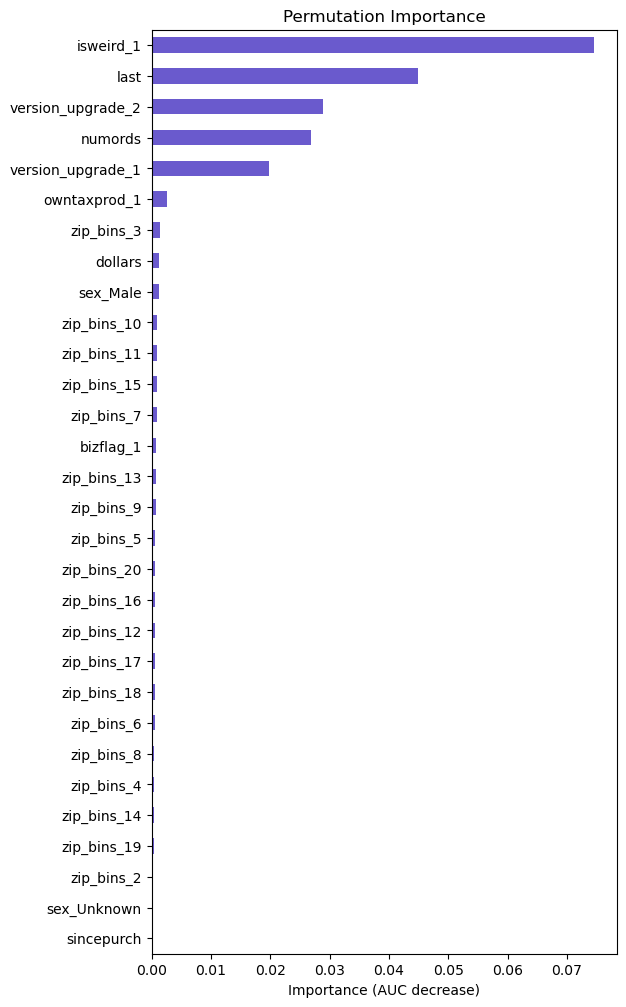

In [59]:
clf4.plot('vimp')

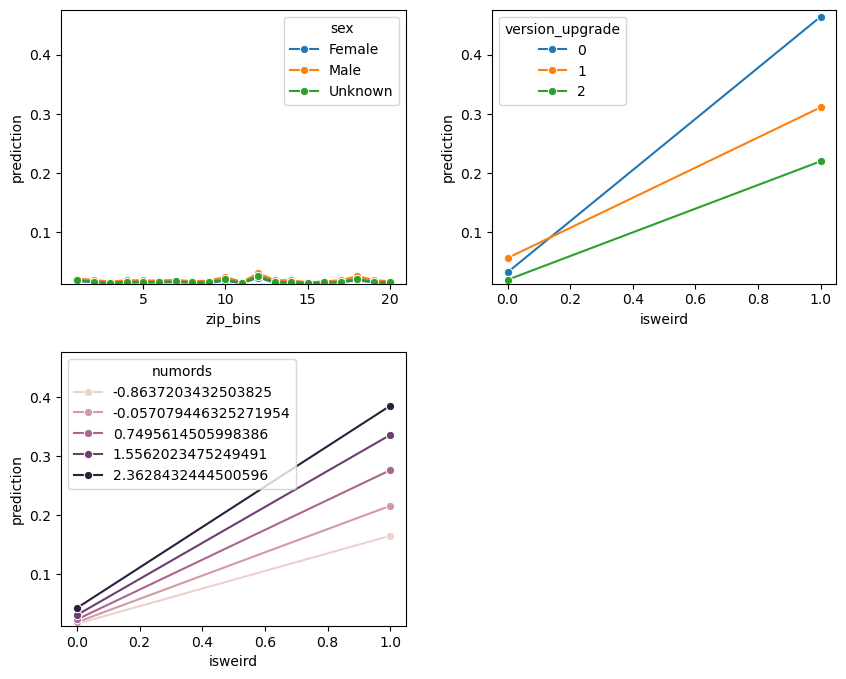

In [60]:
clf4.plot('pred', incl = [], incl_int = ['zip_bins:sex', 'isweird:version_upgrade', 'isweird:numords'])

#### Logistic Regression does not seem to be able to explain this

### Gain Plots

In [61]:
def get_pred2(df, pred_name, model):
    breakeven = 0.0235
    df[pred_name] = model.predict(df)['prediction']
    return "prediction generated"

In [62]:
get_pred2(intuit75k2, 'pred_1', lr)

'prediction generated'

In [63]:
get_pred2(intuit75k2, 'pred_base2', lrfinal2)

'prediction generated'

In [64]:
get_pred2(intuit75k2, 'pred_clf4', clf4)

'prediction generated'

In [65]:
get_pred2(intuit75k2, 'pred_lrnew', lrnew)

'prediction generated'

<Axes: xlabel='Percentage of population targeted', ylabel='Percentage Buyers'>

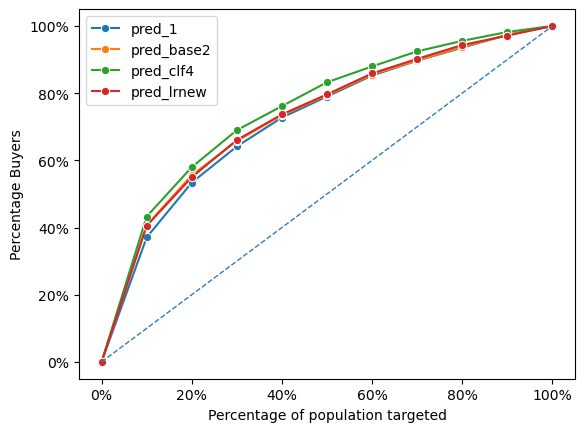

In [66]:
rsm.gains_plot(intuit75k2[intuit75k2['training'] == 1], rvar = 'res1_yes', lev = 1, pred =['pred_1', 'pred_base2', 'pred_clf4', 'pred_lrnew'])

### We will be going with the clf4 model, since it has best gains_plot and highest profit

In [67]:
functions.get_pred(intuit75k2, 'pred_clf4', clf4)

'prediction generated'

In [68]:
functions.calc_profit_scaled(intuit75k2[intuit75k2['training']==0], 'pred_clf4')

(1225587.4549291786, 3.6290157314206506)

### Prediction Generation on Test Set

In [69]:
intuit75k['pred_lrnew'] = intuit75k2['pred_lrnew']

In [70]:
intuit75k.loc[intuit75k['res1_yes'] == 1, 'pred_lrnew'] = False

/tmp/ipykernel_992065/2064481650.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  intuit75k.loc[intuit75k['res1_yes'] == 1, 'pred_lrnew'] = False


In [71]:
pd.read_csv('Jack_Joshua_Mandy_David_Group32.csv')['mailto_wave2'].sum()

6292